In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv("cyberbullying_tweets.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='cyberbullying_type'>

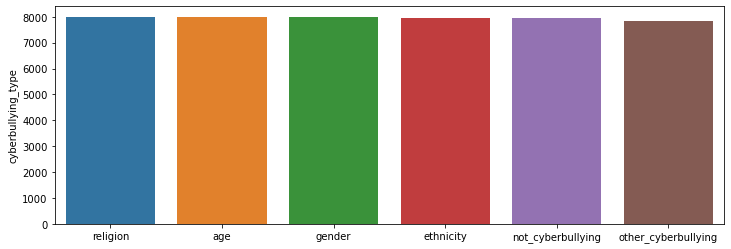

In [4]:
plt.figure(figsize=(12,4))
sns.barplot(df['cyberbullying_type'].value_counts().index, df['cyberbullying_type'].value_counts())

## Observation: All the Data are balanced in our Dataset.

## Tech Preprocessing

By looking into data, one can say it contains urls, punctuations, special characters and emojis. In text preprocessing, we will take care of these elements.

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/avikmukherjee/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

lemmatizer = WordNetLemmatizer()
def lemmatize_word(text):
    return " ".join(lemmatizer.lemmatize(word) for word in str(text).split())

stopword = stopwords.words('english')
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopword])
    
def preprocessing(df, col):
    df['lower'] = df[col].str.lower()
    df['wo_url'] = df['lower'].apply(lambda text: remove_urls(text))
    df['emojis'] = df['wo_url'].apply(lambda text: remove_emoji(text))
    df['wo_punc'] = df['emojis'].apply(lambda text: re.sub('[^a-zA-Z0-9]', ' ', text))
    df['wo_stopword'] = df['wo_punc'].apply(lambda text: remove_stopwords(text))
    df['lemmatized'] = df['wo_stopword'].apply(lambda text: lemmatize_word(text))
    df.drop(['lower', 'wo_url', 'emojis', 'wo_punc', 'wo_stopword', 'tweet_text'], axis=1, inplace=True)
    return df
    

In [8]:
le = LabelEncoder()
df['cyberbullying_type'] = le.fit_transform(df['cyberbullying_type'])
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",3
1,Why is #aussietv so white? #MKR #theblock #ImA...,3
2,@XochitlSuckkks a classy whore? Or more red ve...,3
3,"@Jason_Gio meh. :P thanks for the heads up, b...",3
4,@RudhoeEnglish This is an ISIS account pretend...,3


In [9]:
X = df.drop('cyberbullying_type', axis=1)
y = df['cyberbullying_type']
print("X shape: {} \ny shape: {}".format(X.shape, y.shape))

X shape: (47692, 1) 
y shape: (47692,)


In [10]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=45, stratify=y)

print("train_X shape: {} train_y shape: {}".format(train_X.shape, train_y.shape))
print("test_X shape : {} test_y shape: {}".format(test_X.shape, test_y.shape))

train_X shape: (38153, 1) train_y shape: (38153,)
test_X shape : (9539, 1) test_y shape: (9539,)


In [11]:
train_X = preprocessing(train_X, 'tweet_text')
test_X = preprocessing(test_X, 'tweet_text')

In [12]:
bow = CountVectorizer(max_features=5000)
train_mat_bow = bow.fit_transform(train_X['lemmatized']).toarray()
test_mat_bow = bow.transform(test_X['lemmatized']).toarray()

## Model Training

In [13]:
nb_bow = MultinomialNB()
dt_bow = DecisionTreeClassifier(random_state=42)
rf_bow = RandomForestClassifier(random_state=42)

clfs = {
    "Naive Bayes": nb_bow,
    "Decision Tree": dt_bow,
    "Random Forest": rf_bow
}

def fit_model(clf,x_train,y_train,x_test, y_test):
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_pred, y_test)
    return accuracy

accuracy = []

for name,clf in clfs.items():
    curr_acc = fit_model(clf,train_mat_bow,train_y,test_mat_bow,test_y)
    accuracy.append(curr_acc)
    
models_df = pd.DataFrame({"Models":clfs.keys(),"Accuracy Scores":accuracy}).sort_values('Accuracy Scores',ascending=False)
models_df

,Models,Accuracy Scores
2,Random Forest,0.825139
1,Decision Tree,0.800084
0,Naive Bayes,0.790963


# Conclusions Drawn:

* Random Forest is the best Model for our Dataset.

* It is having the accuracy score of 0.825139.